In [48]:
import tqdm as notebook_tqdm
from text2vec import SentenceModel
import os
import pandas as pd
import torch.nn as nn
import torch
import torch.nn.functional as F
import random
import numpy as np
import torch.optim as optim
from sklearn.model_selection import train_test_split
import copy
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns


## read data

In [49]:
train_data_path = r'./train_engineered.csv'
test_data_path = r'./test_engineered.csv'

model_name = 'all-mpnet-base-v2'
output_folder_name = f'{model_name}-output'
output_path = rf'{os.path.dirname(os.path.abspath("__file__"))}\sentence_embedding\{output_folder_name}'
method_name = 'title_overview_tagline'
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [50]:
data_train = pd.read_csv(train_data_path)[['imdb_id','tagline', 'title', 'overview', 'revenue']]
data_test = pd.read_csv(test_data_path)[['imdb_id','tagline', 'title', 'overview']]

if 'overview' not in data_train.columns or 'title' not in data_train.columns or 'tagline' not in data_train.columns:
    raise ValueError('target columns not found (data_train)')


if 'overview' not in data_test.columns or 'title' not in data_test.columns or 'tagline' not in data_test.columns:
    raise ValueError('target columns not found (data_test)')

all_data = pd.concat([data_train, data_test], ignore_index=True)
print(all_data.shape)

all_data.info()

train_index = data_train.shape[0]
test_index = data_test.shape[0]

print(f"the train/test index is {train_index, test_index}")


(11687, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11687 entries, 0 to 11686
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   imdb_id   11687 non-null  object 
 1   tagline   9774 non-null   object 
 2   title     11684 non-null  object 
 3   overview  11667 non-null  object 
 4   revenue   7289 non-null   float64
dtypes: float64(1), object(4)
memory usage: 456.6+ KB
the train/test index is (7289, 4398)


In [51]:
all_data['overview'].fillna('No overview', inplace=True)
data_overview = all_data['overview'].tolist()

all_data['title'].fillna('No title', inplace=True)
data_title = all_data['title'].tolist()

all_data['tagline'].fillna('No tagline', inplace=True)
data_tagline = all_data['tagline'].tolist()

final_concat = [i + ':'+ k + ':' + j for i, j, k in zip(data_title, data_overview, data_tagline)]
print(final_concat[1])

The Princess Diaries 2: Royal Engagement:It can take a lifetime to find true love; she's got 30 days!:Mia Thermopolis is now a college graduate and on her way to Genovia to take up her duties as princess. Her best friend Lilly also joins her for the summer. Mia continues her 'princess lessons'- riding horses side-saddle, archery, and other royal. But her complicated life is turned upside down once again when she not only learns that she is to take the crown as queen earlier than expected...


## import the embedding model

website: https://huggingface.co/sentence-transformers/all-mpnet-base-v2

In [52]:
m = SentenceModel(model_name_or_path=r'./sentence_embedding/all-mpnet-base-v2')
embeddings_all = m.encode(final_concat)

2023-12-22 19:06:19.948 | DEBUG    | text2vec.sentence_model:__init__:80 - Use device: cuda


## initial visualization

now only deal with train data

In [53]:
embeddings_train = embeddings_all[:train_index]
embeddings_test = embeddings_all[train_index:]
train_data = all_data[:train_index]
test_data = all_data[train_index:]

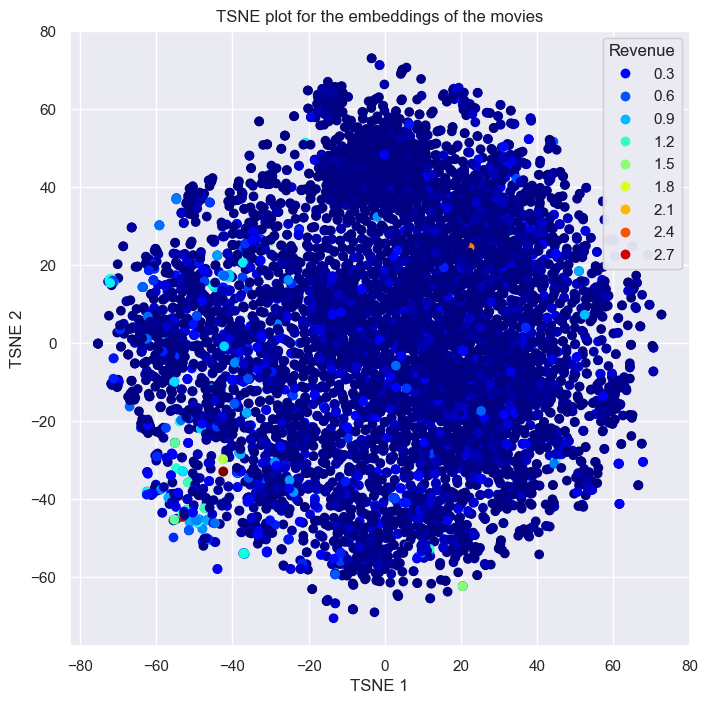

In [54]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(embeddings_train)

# Create the figure
fig_1 = plt.figure(figsize=(8, 8))
ax_1 = fig_1.add_subplot(1, 1, 1)
ax_1.set_title('TSNE plot for the embeddings of the movies')
# Create the scatter plot
scatter = ax_1.scatter(X_2d[:, 0], X_2d[:, 1], c=train_data['revenue'], cmap='jet')
ax_1.set_xlabel('TSNE 1')
ax_1.set_ylabel('TSNE 2')
# Create the legend
legend = ax_1.legend(*scatter.legend_elements(), title='Revenue')
ax_1.add_artist(legend)
#save the plot
plt.savefig(rf"{output_path}\{method_name + '_after_reduced'}.png")
# Show the plot
plt.show()

## reducing the dimensionality

now I will create the full connection layer

In [55]:
class bert_fc_3(nn.Module):
    def __init__(self, input_dim, hidden_dim_1 ,hidden_dim_2,output_dim):
        super(bert_fc_3, self).__init__()
        self.fc_1 = nn.Linear(input_dim, hidden_dim_1)
        self.fc_2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.fc_3 = nn.Linear(hidden_dim_2, output_dim)

    def forward(self, x):
        x = self.fc_1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.1)
        x = self.fc_2(x)
        x = F.dropout(x, p=0.1)
        x = F.relu(x)
        x = self.fc_3(x)
        return x
    
    def output_feature_with_relu(self, x):
        x = self.fc_1(x)
        x = F.relu(x)
        x = self.fc_2(x)
        x = F.relu(x)
        return x
    
    def output_feature_without_relu(self, x):
        x = self.fc_1(x)
        x = F.relu(x)
        x = self.fc_2(x)
        return x

class bert_fc_2(nn.Module):
    def __init__(self, input_dim, hidden_dim_1 ,output_dim):
        super(bert_fc_3, self).__init__()
        self.fc_1 = nn.Linear(input_dim, hidden_dim_1)
        self.fc_2 = nn.Linear(hidden_dim_1, output_dim)

    def forward(self, x):
        x = self.fc_1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.1)
        x = self.fc_2(x)
        return x

In [56]:
def train_model(model, data, optimizer, criterion, device, args):
    epochs = args['epochs']
    
    model.to(device)
    
    train_loss = []
    val_loss = []
    
    fts_train = data['train_fts']
    lbls_train = data['train_lbls']
    fts_val = data['val_fts']
    lbls_val = data['val_lbls']
        
    fts_train = torch.from_numpy(fts_train).to(device)
    lbls_train = torch.from_numpy(lbls_train).to(device).reshape(-1,1)
    fts_val = torch.from_numpy(fts_val).to(device)
    lbls_val = torch.from_numpy(lbls_val).to(device).reshape(-1,1)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = torch.inf
    print(f'train_fts: {fts_train.shape}, train_lbls: {lbls_train.shape}, fts_val: {fts_val.shape}, lbls_val: {lbls_val.shape}')
    converge_counter = 0
    for epoch in notebook_tqdm.tqdm(range(epochs)):
        for state in ['train', 'val']:
            if state == 'train':
                model.train()
                fts = fts_train
                lbls = lbls_train
            else:
                model.eval()
                fts = fts_val
                lbls = lbls_val
                
            pred = model(fts)
            loss = criterion(pred, lbls)
            
            if state == 'train':
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                train_loss.append(loss.item())
            
            else:
                if loss < best_loss:
                    best_loss = loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                val_loss.append(loss.item())
            
        # if (epoch+1) % 50 == 0:
        #     print(f'epoch: {epoch}, train_loss: {train_loss[-1]}, val_loss: {val_loss[-1]}')
                
        if epoch >= 500:
            if val_loss[-2] - val_loss[-1] < 0.001:
                converge_counter += 1
                if converge_counter == 20:
                    print(f'early stopping at epoch: {epoch}')
                    break
            else:
                converge_counter = 0

    model.load_state_dict(best_model_wts)
    print(f'epoch: {epoch}, train_loss: {train_loss[-1]}, val_loss: {val_loss[-1]}')
    return model, train_loss, val_loss

In [57]:
args = dict()
args['input_dim'] = embeddings_train.shape[1]
args['hidden_dim_1'] = 400
args['hidden_dim_2'] = 200
args['output_dim'] = 1
args['epochs'] = 5000
args['lr'] = 0.001

fc_model = bert_fc_3(args['input_dim'],args['hidden_dim_1'],args['hidden_dim_2'], args['output_dim'])

revenue = train_data['revenue'].to_numpy(np.float32)
optimizer = optim.Adam(fc_model.parameters(), lr=args['lr'], weight_decay=0.0001)
criterion = nn.MSELoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
schedular = optim.lr_scheduler.MultiStepLR(optimizer,
                                            milestones=[1000,2000,3000,4000],
                                            gamma=0.9)

In [58]:

X_train, X_val, y_train, y_val = train_test_split(embeddings_train, revenue, test_size=0.2, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

data_fc = dict()
data_fc['train_fts'] = X_train
data_fc['train_lbls'] = np.log1p(y_train)
# data_fc['train_lbls'] = y_train
data_fc['val_fts'] = X_val
data_fc['val_lbls'] = np.log1p(y_val)
# data_fc['val_lbls'] = y_test

model, train_loss, val_loss = train_model(fc_model, data_fc, optimizer, criterion, device, args)

(5831, 768) (1458, 768) (5831,) (1458,)
train_fts: torch.Size([5831, 768]), train_lbls: torch.Size([5831, 1]), fts_val: torch.Size([1458, 768]), lbls_val: torch.Size([1458, 1])


  0%|          | 4/5000 [00:00<02:57, 28.11it/s]

100%|██████████| 5000/5000 [02:52<00:00, 28.99it/s]

epoch: 4999, train_loss: 0.4930140972137451, val_loss: 5.632907390594482


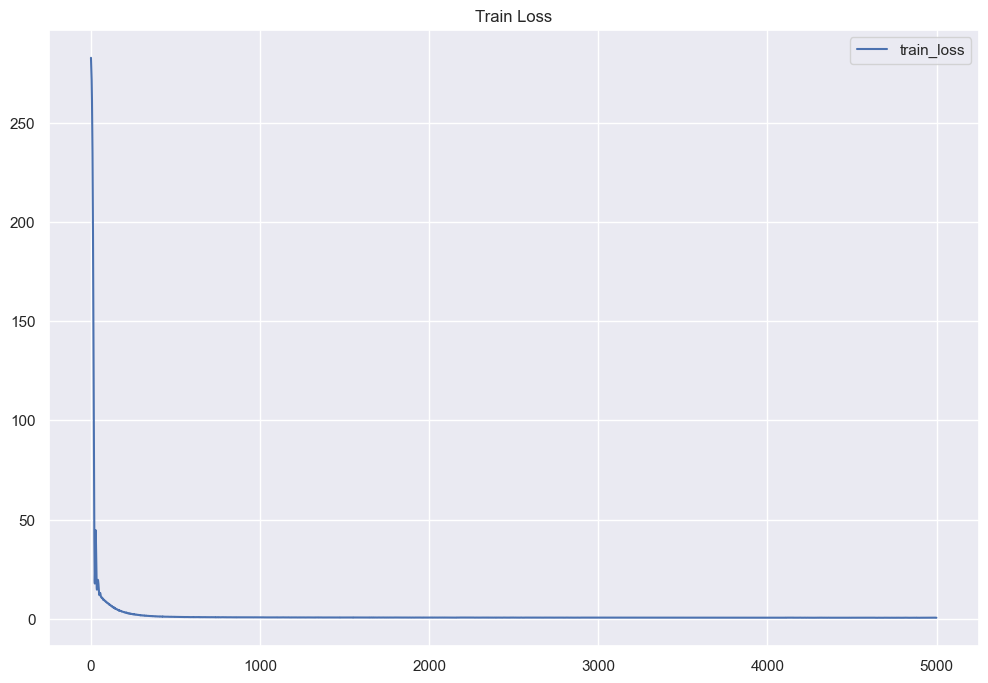

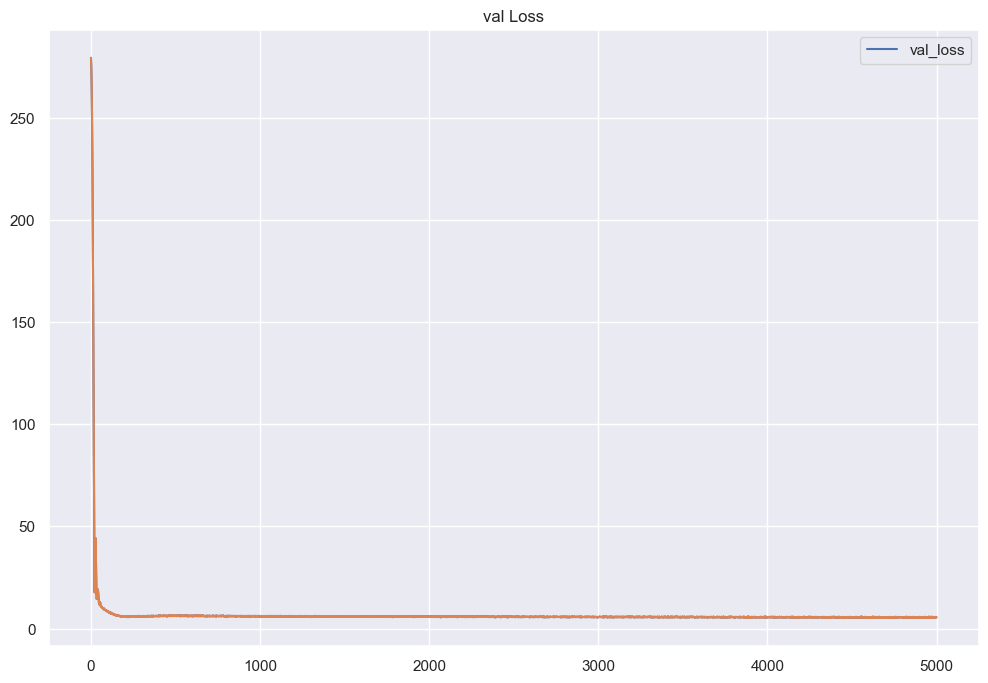

In [59]:
plt.figure()
plt.plot(train_loss, label='train_loss')
plt.legend()
plt.title('Train Loss')

plt.figure()
plt.plot(val_loss, label='val_loss')
plt.legend()
plt.title('val Loss')
plt.plot(val_loss, label='val_loss')

In [60]:
print(train_loss)

[282.9405517578125, 280.44256591796875, 278.1391906738281, 275.406005859375, 271.8816833496094, 267.28173828125, 261.4261779785156, 254.15147399902344, 245.36624145507812, 234.9733428955078, 222.9575958251953, 209.20913696289062, 193.72607421875, 176.67645263671875, 157.9307861328125, 138.2406768798828, 117.48906707763672, 96.32861328125, 75.76811218261719, 56.563316345214844, 39.78553009033203, 27.033109664916992, 19.38068199157715, 17.745695114135742, 22.35175132751465, 30.729286193847656, 39.13113021850586, 44.29732894897461, 44.626251220703125, 41.34242630004883, 35.47389602661133, 29.13026237487793, 23.057430267333984, 18.657194137573242, 15.558491706848145, 14.6673002243042, 14.766805648803711, 15.728825569152832, 17.040016174316406, 18.342748641967773, 19.060592651367188, 19.617773056030273, 19.28749656677246, 18.64177703857422, 17.69515037536621, 16.243778228759766, 14.911073684692383, 13.611058235168457, 12.749238014221191, 12.036452293395996, 11.867789268493652, 12.0942554473

5.453424 0.07536114801618132
Spearman correlation: 0.4105572421800146
[[15.330654]
 [16.592344]
 [15.275805]
 [17.142872]
 [15.870653]
 [17.049894]
 [18.55653 ]
 [15.918269]
 [17.475965]
 [18.866581]]
[18.35155  17.346363 15.537442 11.626227 20.38974  14.10069  19.679466
  9.546884 10.522773 17.098457]


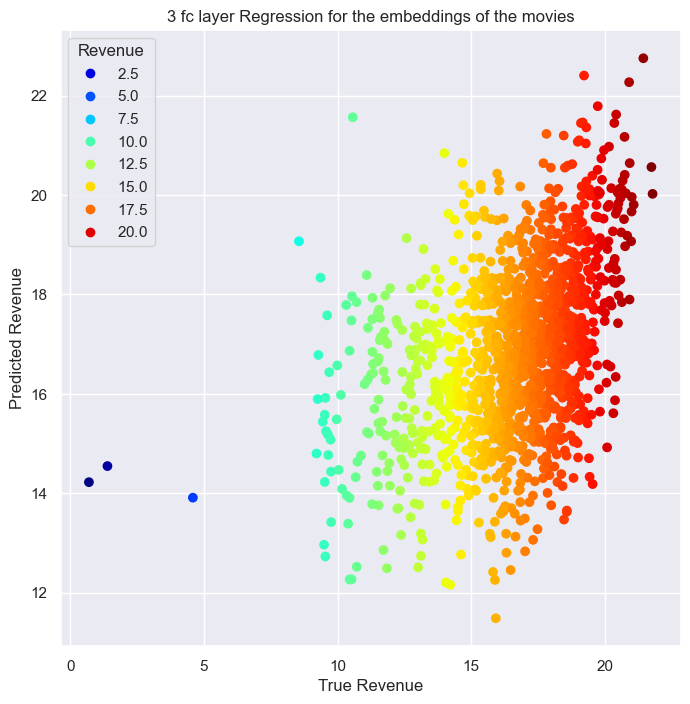

In [61]:
model.eval()
preds = model(torch.from_numpy(X_val).to(device)).cpu().detach().numpy()

# preds_draw = np.log1p(preds)
# revenue_draw = np.log1p(y_test)

preds_draw = preds
revenue_draw = data_fc['val_lbls']

# visualize the results
# Create the figure
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('3 fc layer Regression for the embeddings of the movies')
# Create the scatter plot
scatter = ax.scatter(revenue_draw, preds_draw, c=revenue_draw, cmap='jet')
ax.set_xlabel('True Revenue')
ax.set_ylabel('Predicted Revenue')

spearman_corr, _ = spearmanr(revenue_draw, preds_draw)
ax.legend(*scatter.legend_elements(), loc="upper left", title="Revenue")
plt.savefig(rf'{output_path}\{method_name + str(round(spearman_corr, 4))}.png')

acc = mean_squared_error(revenue_draw, preds_draw)
R2 = r2_score(revenue_draw, preds_draw)

print(acc, R2)

print(f"Spearman correlation: {spearman_corr}")
print(preds_draw[:10])
print(revenue_draw[:10])



In [62]:
feature_train = fc_model.output_feature_without_relu(torch.from_numpy(embeddings_train).to(device)).cpu().detach().numpy()
print(feature_train.shape)
feature_test = fc_model.output_feature_without_relu(torch.from_numpy(embeddings_test).to(device)).cpu().detach().numpy()
print(feature_test.shape)

(7289, 200)
(4398, 200)


In [63]:
feature_train_relu = fc_model.output_feature_with_relu(torch.from_numpy(embeddings_train).to(device)).cpu().detach().numpy()
print(feature_train.shape)
feature_test_relu = fc_model.output_feature_with_relu(torch.from_numpy(embeddings_test).to(device)).cpu().detach().numpy()
print(feature_test.shape)

(7289, 200)
(4398, 200)


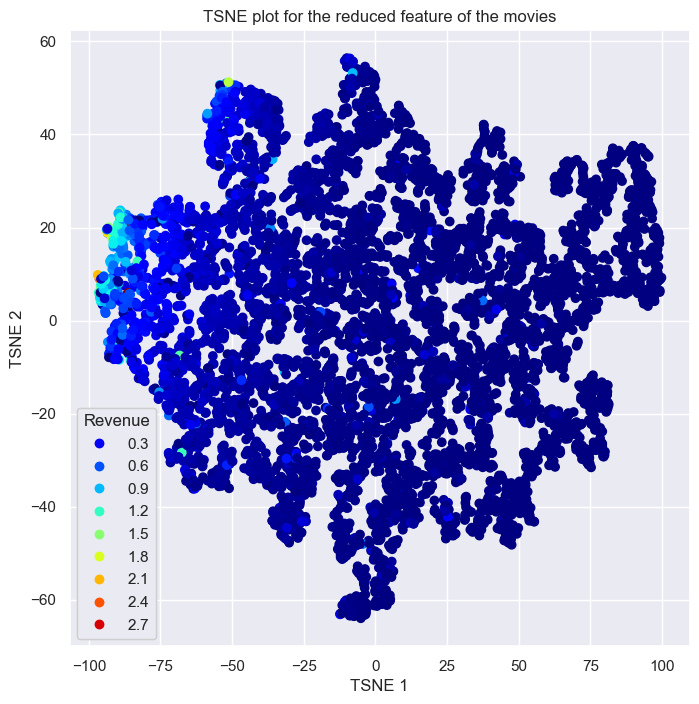

In [64]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(feature_train)

# Create the figure
fig_1 = plt.figure(figsize=(8, 8))
ax_1 = fig_1.add_subplot(1, 1, 1)
ax_1.set_title('TSNE plot for the reduced feature of the movies')
# Create the scatter plot
scatter = ax_1.scatter(X_2d[:, 0], X_2d[:, 1], c=train_data['revenue'], cmap='jet')
ax_1.set_xlabel('TSNE 1')
ax_1.set_ylabel('TSNE 2')
# Create the legend
legend = ax_1.legend(*scatter.legend_elements(), title='Revenue')
ax_1.add_artist(legend)
# Show the plot
plt.savefig(rf"{output_path}\{method_name + '_after_reduced'}.png")
plt.show()


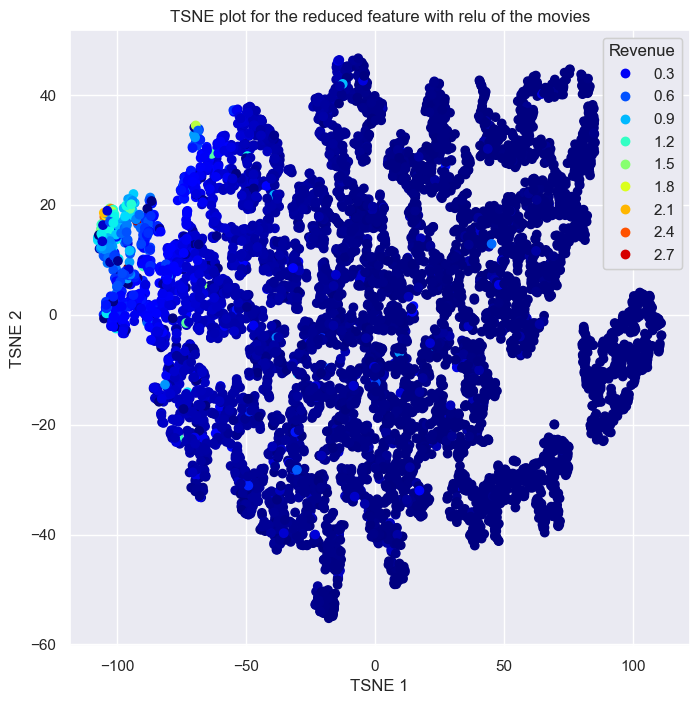

In [65]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(feature_train_relu)

# Create the figure
fig_1 = plt.figure(figsize=(8, 8))
ax_1 = fig_1.add_subplot(1, 1, 1)
ax_1.set_title('TSNE plot for the reduced feature with relu of the movies')
# Create the scatter plot
scatter = ax_1.scatter(X_2d[:, 0], X_2d[:, 1], c=train_data['revenue'], cmap='jet')
ax_1.set_xlabel('TSNE 1')
ax_1.set_ylabel('TSNE 2')
# Create the legend
legend = ax_1.legend(*scatter.legend_elements(), title='Revenue')
ax_1.add_artist(legend)
# Show the plot
plt.savefig(rf"{output_path}\{method_name + '_after_reduced_relu'}.png")
plt.show()


C:\Users\Dennis\AppData\Local\Temp\ipykernel_18404\2338258435.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=np.log1p(data), kde = False, ax = ax, color=color, hist_kws=dict(alpha=1))


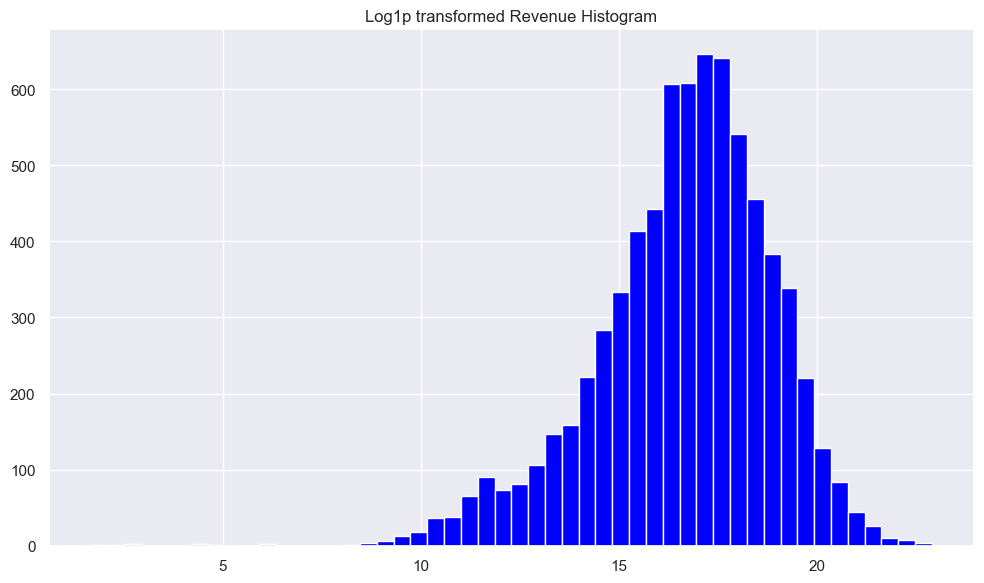

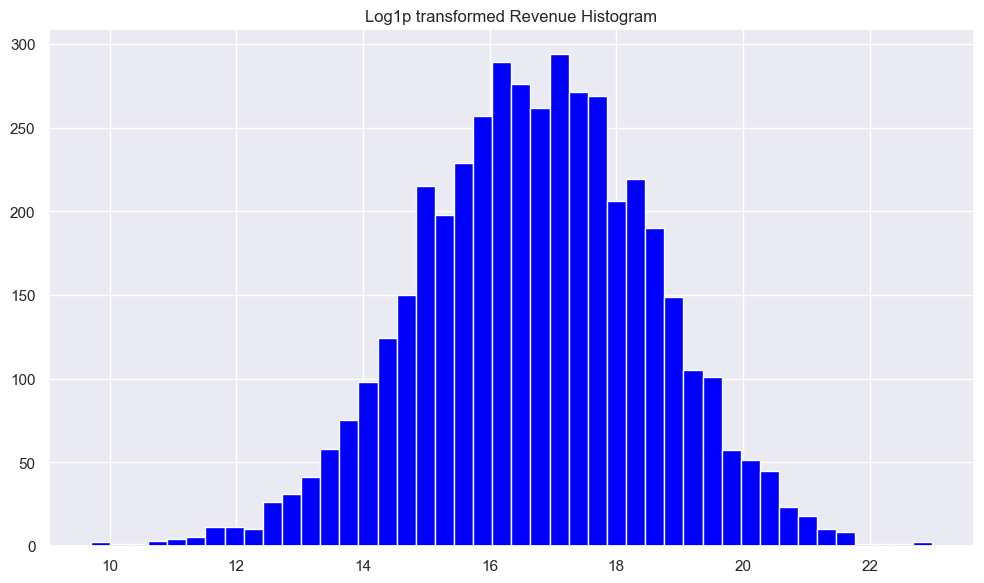

In [66]:
def plot_dist(field, color, data):
    f, ax = plt.subplots(1, figsize=(10,6))
    sns.distplot(a=np.log1p(data), kde = False, ax = ax, color=color, hist_kws=dict(alpha=1))
    ax.set_title(f"Log1p transformed {field} Histogram")
    f.tight_layout()

one_dim_feature_train = model(torch.from_numpy(embeddings_train).to(device)).cpu().detach().numpy()
one_dim_feature_test = model(torch.from_numpy(embeddings_test).to(device)).cpu().detach().numpy()

one_dim_feature_train_df = pd.DataFrame(one_dim_feature_train, columns=['log_feature'])
one_dim_feature_test_df = pd.DataFrame(one_dim_feature_test, columns=['log_feature'])

one_dim_feature_train = np.expm1(one_dim_feature_train.flatten())
one_dim_feature_test = np.expm1(one_dim_feature_test.flatten())

one_dim_feature_train_df['original_pred'] = one_dim_feature_train
one_dim_feature_test_df['original_pred'] = one_dim_feature_test

one_dim_feature_train_df['original_pred'] = one_dim_feature_train
one_dim_feature_test_df['original_pred'] = one_dim_feature_test

plot_dist('Revenue', 'blue', one_dim_feature_train)
plot_dist('Revenue', 'blue', one_dim_feature_test)

one_dim_feature_train_df['imdb_id'] = data_train['imdb_id']
one_dim_feature_test_df['imdb_id'] = data_test['imdb_id']

one_dim_feature_train_df.to_csv(rf"{output_path}\..\one_dim_feature_train.csv", index=False, header=True)
one_dim_feature_test_df.to_csv(rf"{output_path}\..\one_dim_feature_test.csv", index=False, header=True)

In [67]:
feature_train_df = pd.DataFrame(feature_train)
feature_test_df = pd.DataFrame(feature_test)
feature_train_relu_df = pd.DataFrame(feature_train_relu)
feature_test_relu_df = pd.DataFrame(feature_test_relu)
embedding_train_df = pd.DataFrame(embeddings_train)
embedding_test_df = pd.DataFrame(embeddings_test)

train_imdb_id = data_train['imdb_id']
test_imdb_id = data_test['imdb_id']

feature_train_df['imdb_id'] = train_imdb_id
feature_test_df['imdb_id'] = test_imdb_id
feature_train_relu_df['imdb_id'] = train_imdb_id
feature_test_relu_df['imdb_id'] = test_imdb_id
embedding_train_df['imdb_id'] = train_imdb_id
embedding_test_df['imdb_id'] = test_imdb_id

feature_train_df.to_csv(rf"{output_path}\..\feature_train.csv", index=False)
feature_test_df.to_csv(rf"{output_path}\..\feature_test.csv", index=False)

feature_train_relu_df.to_csv(rf"{output_path}\..\feature_train_relu.csv", index=False)
feature_test_relu_df.to_csv(rf"{output_path}\..\feature_test_relu.csv", index=False)

embedding_train_df.to_csv(rf"{output_path}\..\embeddings_train.csv", index=False)
embedding_test_df.to_csv(rf"{output_path}\..\embeddings_test.csv", index=False)
